In [1]:
!pip install tensorflow pennylane pennylane-lightning qiskit scikit-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 11.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import os

In [3]:
dataset_path = '/content/Dataset/'
classes = ['CT', 'MRI', 'Xray']
img_size = (128, 128)  # Smaller size for faster processing

In [4]:
def extract_features_labels():
    features = []
    labels = []
    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = imread(img_path)
            img = resize(img, img_size)  # Resize to uniform dimensions
            img_gray = np.mean(img, axis=2)  # Convert to grayscale (HOG works better)
            hog_feat = hog(img_gray, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1))
            features.append(hog_feat)
            labels.append(class_idx)
    return np.array(features), np.array(labels)

X, y = extract_features_labels()
print(f"Total samples: {len(X)} | Features per sample: {X.shape[1]}")

Total samples: 28 | Features per sample: 512


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train samples: {len(X_train)} | Test samples: {len(X_test)}")

Train samples: 22 | Test samples: 6


In [6]:
svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("=== SVM ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.2f}")
print(classification_report(y_test, y_pred_svm, target_names=classes))

=== SVM ===
Accuracy: 0.33
              precision    recall  f1-score   support

          CT       0.50      0.33      0.40         3
         MRI       0.00      0.00      0.00         1
        Xray       1.00      0.50      0.67         2

    accuracy                           0.33         6
   macro avg       0.50      0.28      0.36         6
weighted avg       0.58      0.33      0.42         6



In [7]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("=== Random Forest ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(classification_report(y_test, y_pred_rf, target_names=classes))

=== Random Forest ===
Accuracy: 0.50
              precision    recall  f1-score   support

          CT       0.67      0.67      0.67         3
         MRI       0.00      0.00      0.00         1
        Xray       1.00      0.50      0.67         2

    accuracy                           0.50         6
   macro avg       0.56      0.39      0.44         6
weighted avg       0.67      0.50      0.56         6



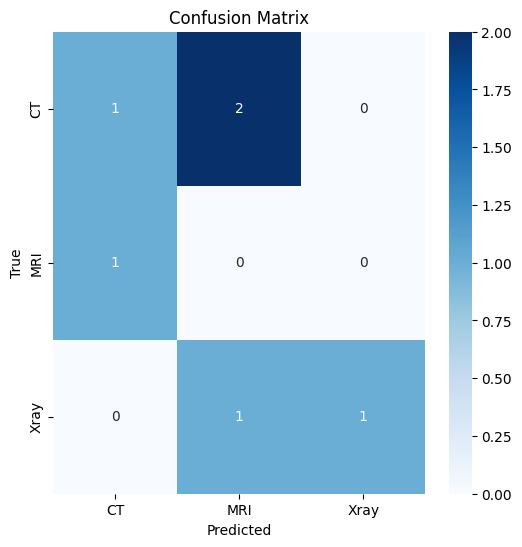

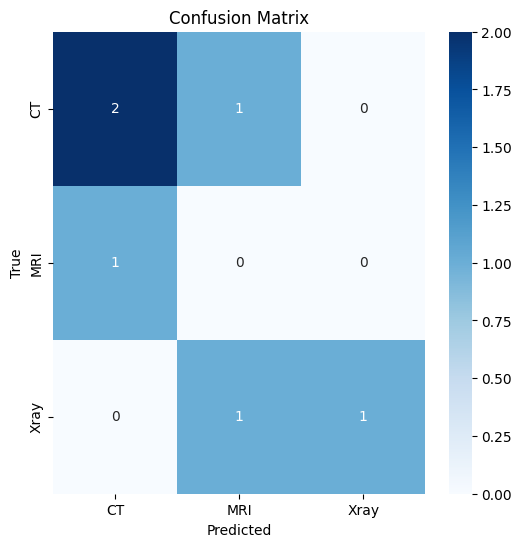

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test, y_pred_svm, classes)
plot_confusion_matrix(y_test, y_pred_rf, classes)

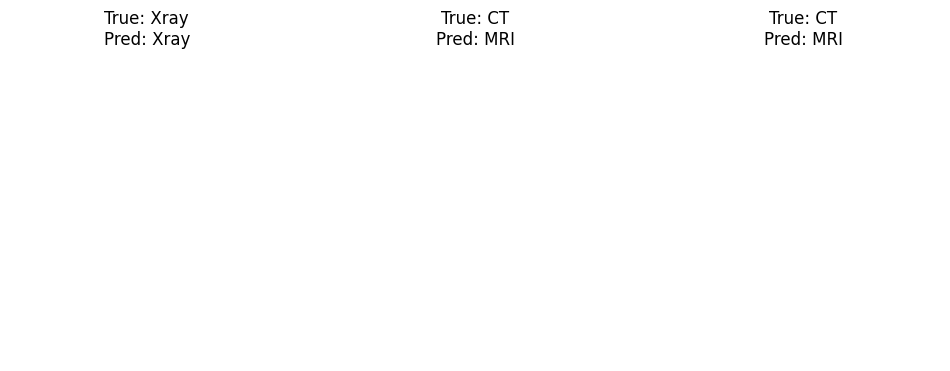

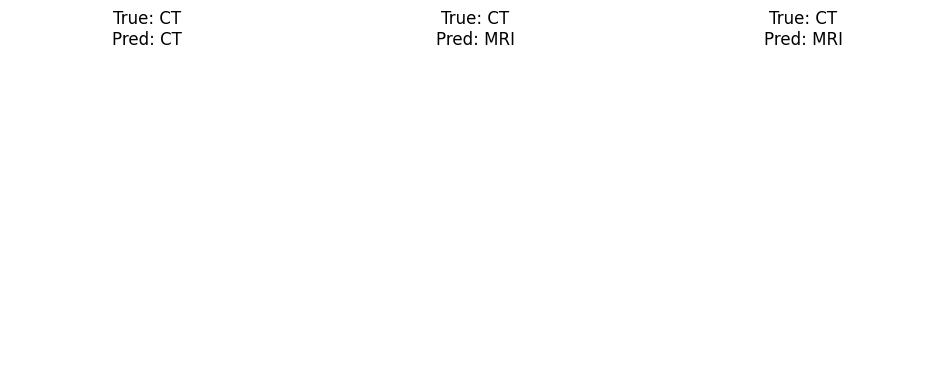

In [9]:
def show_sample_predictions(model, X_test, y_test, n_samples=3):
    plt.figure(figsize=(12, 4))
    for i in range(n_samples):
        idx = np.random.randint(0, len(X_test))
        pred = model.predict(X_test[idx].reshape(1, -1))[0]
        plt.subplot(1, n_samples, i+1)
        plt.title(f"True: {classes[y_test[idx]]}\nPred: {classes[pred]}")
        plt.axis('off')
    plt.show()

show_sample_predictions(svm, X_test, y_test)
show_sample_predictions(rf, X_test, y_test)

In [10]:
print(f"RF Accuracy: {rf.score(X_test, y_test):.2f}")
print(f"SVM Accuracy: {svm.score(X_test, y_test):.2f}")

RF Accuracy: 0.50
SVM Accuracy: 0.33


In [11]:
import joblib

# Save models
joblib.dump(svm, 'svm_model.pkl')
joblib.dump(rf, 'random_forest_model.pkl')

# Load models
svm_loaded = joblib.load('svm_model.pkl')
rf_loaded = joblib.load('random_forest_model.pkl')

Prediction of new input

In [12]:
# 1. Install required packages (run once)
!pip install scikit-image joblib matplotlib numpy scikit-learn

In [13]:
# 2. Import libraries
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from google.colab import files
import numpy as np
import joblib
import matplotlib.pyplot as plt

In [14]:
# 3. Define preprocessing function (must match training)
def preprocess_image(image_path, img_size=(128, 128)):
    """Process JPEG images to HOG features"""
    try:
        img = imread(image_path)
        if len(img.shape) == 3:  # Color image
            img = np.mean(img, axis=2)  # Convert to grayscale
        img = resize(img, img_size)
        features = hog(img,
                      orientations=8,
                      pixels_per_cell=(16, 16),
                      cells_per_block=(1, 1))
        return features.reshape(1, -1)
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

Please upload a JPEG image:


Saving download.jpeg to download.jpeg
Model loaded successfully


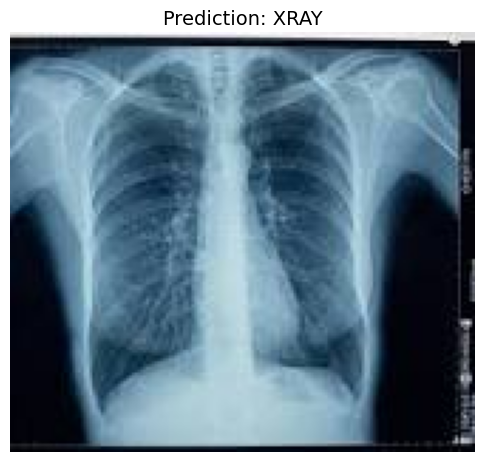


Final Prediction: xray


In [15]:
# 4. Upload your JPEG image
print("Please upload a JPEG image:")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# 5. Load model (replace with your actual model file)
try:
    model = joblib.load('svm_model.pkl')  # Or 'rf_model.pkl'
    print("Model loaded successfully")
except FileNotFoundError:
    print("Model file not found! Please upload:")
    files.upload()  # Upload your .pkl file
    model = joblib.load('svm_model.pkl')

# 6. Predict and show results
classes = ['ct', 'mri', 'xray']  # Must match training order

features = preprocess_image(image_path)
if features is not None:
    prediction = model.predict(features)
    class_name = classes[prediction[0]]

    # Display results
    plt.figure(figsize=(6, 6))
    plt.imshow(imread(image_path))
    plt.axis('off')
    plt.title(f"Prediction: {class_name.upper()}", fontsize=14)
    plt.show()
    print(f"\nFinal Prediction: {class_name}")

CNN

In [16]:
# Install required libraries
!pip install tensorflow scikit-image matplotlib

import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Load and preprocess data (CT/MRI/X-ray)
def load_data(data_dir, img_size=(128, 128)):
    images = []
    labels = []
    class_names = ['CT', 'MRI', 'Xray']  # Folder names must match

    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = imread(img_path)
            img = resize(img, img_size)  # Resize to consistent dimensions
            img = img / 255.0  # Normalize to [0,1]
            images.append(img)
            labels.append(class_idx)

    return np.array(images), np.array(labels)

# Build CNN model
def create_cnn_model(input_shape=(128, 128, 3), num_classes=3):
    model = models.Sequential([
        # Convolutional layers
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),

        # Classifier head
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

# Usage
data_dir = '/content/Dataset'  # Folder with 'ct', 'mri', 'xray' subfolders
X, y = load_data(data_dir)
model = create_cnn_model(input_shape=X[0].shape)
model.fit(X, y, epochs=10, validation_split=0.2)

# Save model
model.save('medical_cnn.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.1818 - loss: 1.0987 - val_accuracy: 0.0000e+00 - val_loss: 1.1804
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 1.0678 - val_accuracy: 0.0000e+00 - val_loss: 1.6840
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step - accuracy: 0.5000 - loss: 0.9659 - val_accuracy: 0.0000e+00 - val_loss: 3.1544
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step - accuracy: 0.5000 - loss: 0.9833 - val_accuracy: 0.0000e+00 - val_loss: 3.1280
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 0.9503 - val_accuracy: 0.0000e+00 - val_loss: 2.6550
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4091 - loss: 0.9474 - val_accuracy: 0.0000e+00 - val_loss: 2.1511
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4091 - loss: 0.9399 - val_accuracy: 0.0000e+00 - val_loss: 1.9058
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 0.9459 - val_accuracy: 0.0000e+

Quantum Machine Learning Pipeline

In [3]:
!pip install pennylane==0.32.0 pennylane-lightning tensorflow==2.12.0
!pip install numpy==1.23.5


  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.23.5 which is incompatible.
xarray 2025.7.1 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 w

In [1]:
import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.qnn import KerasLayer
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

In [2]:
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [3]:
# Hybrid model creation
def create_hybrid_model(input_shape=(128, 128, 3)):
    # Classical feature extractor
    cnn = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten()
    ])

    # Quantum layer configuration
    weight_shapes = {"weights": (1, n_qubits, 3)}  # StronglyEntanglingLayers format

    # Wrap quantum circuit as a Keras Layer
    qlayer = KerasLayer(
        quantum_circuit,
        weight_shapes=weight_shapes,
        output_dim=n_qubits,
        dtype=tf.float32  # Add dtype for TensorFlow compatibility
    )

    # Full hybrid model
    model = models.Sequential([
        cnn,
        layers.Dense(n_qubits, activation='relu'),  # Bridge to quantum
        qlayer,
        layers.Dense(3, activation='softmax')  # Output for 3 classes
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [4]:
# Test the model with dummy data
model = create_hybrid_model()
X_dummy = np.random.rand(5, 128, 128, 3)  # 5 fake images
y_dummy = np.random.randint(0, 3, size=5)
model.fit(X_dummy, y_dummy, epochs=1)  # Should run without errors
print("Model works successfully!")

1/1 [==============================] - 1s 589ms/step - loss: 1.1635 - accuracy: 0.4000
Model works successfully!
